# Negative Data Set Creator

- Need to collect data from preprocessed set
- remove genes also in positive data set
- remove genes that don't contain the CTCCA motif

Our positive data is saved in \out as 'Positive_NSUN6_3070.csv'


## Imports & Path Set-up


In [67]:
sample_count_threshold = 50;
NSUN6_NSUN2_cutoff_factor = 0.6; #arbitrary at the moment, between 0 and 1

import random
import math
import pandas as pd
import numpy as np
from pyfaidx import Fasta
import matplotlib.pyplot as plt
from matplotlib import colors
import logomaker as lm
import re

PATH = '../GenomeData/'


## Functions


In [68]:
def count_iterable(i):
    return sum(1 for e in i)

def extract_seq_genome(genome, chrom, start, end, strand = '+'):
    '''
    ath: tair10
    cel: cel235
    hsa: hg38
    mmu: mm10

    Usage:
        - If strand == '+', return sequence
        - If strand == '-', return sequence revese complementary
        - With hg38.get_seq(chrom, start, end, rc= strand == '-').seq get correct position of miRNA,
        for mapping result, you should modify by yourself.
    '''
    
    if genome == 'cel':
        genome = 'cel235'
    elif genome == 'hsa':
        genome = 'hg38'
    elif genome == 'mmu':
        genome = 'mm10'
    elif genome == 'ath':
        genome = 'tair10'
    elif genome == 'mml':
        genome = 'Macaca_mulatta.Mmul_10.dna.toplevel'
    elif genome == 'dre':
        genome = 'Danio_rerio.GRCz11.dna.primary_assembly'
    elif genome == 'dme':
        genome = 'Drosophila_melanogaster.BDGP6.32.dna.toplevel'


    gene = Fasta(f"{PATH}/{genome}.fa") 
    
    #hg38.get_seq('chr1', 100009588 + 1, 100009608, rc=False).seq
    return(gene.get_seq(chrom, start+1, end, rc= strand == '-').seq)

## [SAME AS LAST FILE]

In [69]:
ubsseq_data_raw = pd.read_excel("ubsseq_preprocessed_data.xlsx")
ubsseq_data_raw_shape = ubsseq_data_raw.shape
ubsseq_data_sample_count = ubsseq_data_raw[['unconverted', 'converted']].sum(axis=1)
ubsseq_data_significant = ubsseq_data_raw[ubsseq_data_sample_count > sample_count_threshold]
ubsseq_data_significant = ubsseq_data_significant[ubsseq_data_significant['chrom'] != 'MT']
ubsseq_data_significant_shape = ubsseq_data_significant.shape
print(f"Filtered data contains {ubsseq_data_significant_shape[0]} genes out of an initial {ubsseq_data_raw_shape[0]} genes, a {ubsseq_data_significant_shape[0]/ubsseq_data_raw_shape[0]*100:.2f}% retention")

#We might want to also explore data we assume not be modified by NSUN6, likely NSUN2
a, b = np.polyfit(ubsseq_data_significant['ratio_siControl'], ubsseq_data_significant['ratio_siNSUN6'], 1)
a = a - NSUN6_NSUN2_cutoff_factor
ideal_delta_threshold = 1 - a + b
ubsseq_data_NSUN2 = ubsseq_data_significant[ubsseq_data_significant['delta_ratio'] < ideal_delta_threshold]
ubsseq_data_NSUN2=ubsseq_data_NSUN2.drop([
    'gene_type','gene_pos','unconverted','converted','ratio_siControl','ratio_siNSUN6','delta_ratio'
    ], axis=1)

ubsseq_data_NSUN2['chrom'] = ubsseq_data_NSUN2['chrom'].replace(
    [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22, 'X'], 
    ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX'])

seq_extract = [[],[],[]];

for ind in ubsseq_data_NSUN2.index:
    gene = ubsseq_data_NSUN2['gene_name'][ind]
    chrome = ubsseq_data_NSUN2['chrom'][ind]
    strand = ubsseq_data_NSUN2['strand'][ind]
    pos = ubsseq_data_NSUN2['pos'][ind]
    seq_extract[0].append(extract_seq_genome("hg38", chrome, pos-1-50, pos+50, strand)) #50:50
    seq_extract[1].append(extract_seq_genome("hg38", chrome, pos-1-30, pos+70, strand)) #30:70
    seq_extract[2].append(extract_seq_genome("hg38", chrome, pos-1-70, pos+30, strand)) #70:30

ubsseq_NSUN2_extracted = ubsseq_data_NSUN2.assign(
    seq5050=seq_extract[0], seq3070=seq_extract[1], seq7030=seq_extract[2])

c:\Users\joele\JoelsPrograms\miniconda3\envs\MLRNA\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\joele\JoelsPrograms\miniconda3\envs\MLRNA\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


Filtered data contains 1594 genes out of an initial 2140 genes, a 74.49% retention


## Sort Data For Likely-NSUN2 with CTCCA motif

In [70]:

motif='CTCCA'
Q=re.compile(motif)

NSUN2_CTCCA = pd.DataFrame(index=range(0),columns=ubsseq_NSUN2_extracted.columns)
NSUN2_extracted = ubsseq_NSUN2_extracted['seq5050'].to_list()
for i in range (0, len(NSUN2_extracted)):
    seq=NSUN2_extracted[i]
    motif_occurrence = count_iterable(Q.finditer(seq[45:56]))
    if(motif_occurrence != 0):
        entry = ubsseq_NSUN2_extracted.loc[ubsseq_NSUN2_extracted['seq5050'] == seq]
        NSUN2_CTCCA = pd.concat([NSUN2_CTCCA,entry])

print(NSUN2_CTCCA.shape)

(76, 7)


We can generate logos to check motif occurrence 

Text(0, 0.5, 'Information (bits)')

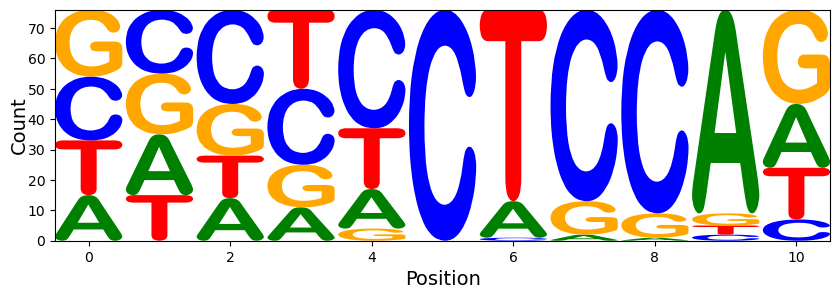

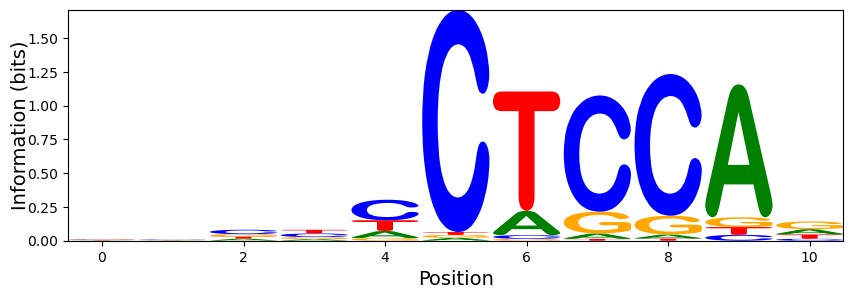

In [71]:
NSUN2_extracted_CTCCA = NSUN2_CTCCA['seq5050'].to_list()
for i in range (0, len(NSUN2_extracted_CTCCA)):
    NSUN2_extracted_CTCCA[i] = NSUN2_extracted_CTCCA[i][45:56]
counts_mat = lm.alignment_to_matrix(NSUN2_extracted_CTCCA)

# Counts matrix -> Information matrix
info_mat = lm.transform_matrix(counts_mat, from_type='counts', to_type='information')

logo_count = lm.Logo(df=counts_mat,
               font_name='Arial Rounded MT Bold',
               figsize=(10,3)) # Can change to plot entropy or percentage instead of count
logo_count.ax.set_xlabel('Position',fontsize=14)
logo_count.ax.set_ylabel('Count', labelpad=-1,fontsize=14)

logo_info = lm.Logo(df=info_mat,
               font_name='Arial Rounded MT Bold',
               figsize=(10,3)) # Can change to plot entropy or percentage instead of count
logo_info.ax.set_xlabel('Position',fontsize=14)
logo_info.ax.set_ylabel('Information (bits)', labelpad=-1,fontsize=14)

## Get Structure

In [74]:
NSUN2_CTCCA_fasta = []
NSUN2_CTCCA_csv = []
for ind in NSUN2_CTCCA.index:
    gene_name = NSUN2_CTCCA['gene_name'][ind]
    NSUN2_CTCCA_fasta.append('>%s_5050\n%s' % (gene_name, NSUN2_CTCCA['seq5050'][ind]))
    NSUN2_CTCCA_fasta.append('>%s_3070\n%s' % (gene_name, NSUN2_CTCCA['seq3070'][ind]))
    NSUN2_CTCCA_fasta.append('>%s_7030\n%s' % (gene_name, NSUN2_CTCCA['seq7030'][ind]))
    NSUN2_CTCCA_csv.append('%s,5050,%s' % (gene_name, NSUN2_CTCCA['seq5050'][ind]))
    NSUN2_CTCCA_csv.append('%s,3070,%s' % (gene_name, NSUN2_CTCCA['seq3070'][ind]))
    NSUN2_CTCCA_csv.append('%s,7030,%s' % (gene_name, NSUN2_CTCCA['seq7030'][ind]))

with open('out/NSUN2_CTCCA.fasta', 'w') as file:
     file.write('\n'.join(NSUN2_CTCCA_fasta))

with open('out/NSUN2_CTCCA.csv', 'w') as file:
     file.write('\n'.join(NSUN2_CTCCA_csv))

Using the same terminal scripts as last time to get base pairing probabilities

Reformat base pairing probabilities

In [78]:
bpp_data = pd.read_csv(r"out\NSUN2_CTCCA_bpp.csv")
current_head = bpp_data.columns
bpp_data.columns = ['pair', 'P', 'gene', 'selection']
bpp_data.loc[len(bpp_data.index)] = current_head
#print(bpp_data)

seq_data = pd.read_csv(r"out/NSUN2_CTCCA.csv")
current_head = seq_data.columns
seq_data.columns = ['gene','selection', 'seq']
seq_data.loc[len(seq_data.index)] = current_head

bpp_3070 = bpp_data[bpp_data['selection'] == 3070].drop('selection', axis=1)
bpp_5050 = bpp_data[bpp_data['selection'] == 5050].drop('selection', axis=1)
bpp_7030 = bpp_data[bpp_data['selection'] == 7030].drop('selection', axis=1)


## For 3070
seq_3070 = seq_data[seq_data['selection'] == 3070].drop_duplicates(subset=['gene'])
all_genes = seq_3070['gene'].to_list()
all_seq = seq_3070['seq'].to_list()
all_pairs = pd.unique(bpp_3070['pair'])

df_pairs_probs = pd.DataFrame(index=range(len(all_genes)),columns=all_pairs)
total_pairs_count = len(all_pairs)

i = 0;
for gene in all_genes:
    pairs_with_probs = bpp_3070.loc[bpp_3070['gene'] == gene].drop('gene', axis=1)
    for pair in pairs_with_probs['pair']:
        probability = pairs_with_probs[pairs_with_probs['pair']==pair]['P'].to_list()[0]
        df_pairs_probs.loc[i,pair] = probability;
    i = i+1
print(df_pairs_probs.shape)

# Concatenate along the first axis (rows)
restruct_name_seq = pd.DataFrame([all_genes, all_seq]).T
restruct_name_seq.columns=['gene','seq']
final_data = pd.concat([restruct_name_seq,df_pairs_probs], axis=1)
final_data.to_csv('out/Negative_NSUN6_3070.csv', index=False)


(76, 4751)
(76, 2)
